In [7]:
from training_functions import *
from merging import *
from utils import *
from model_evaluation import ModelEvaluation
import pandas as pd

In [2]:
def join_data_and_preds_exp(
    df_preds_full_mp: pd.DataFrame,
    df_data_exp_mp: pd.DataFrame,
) -> pd.DataFrame:
    df_preds_mp_exp = df_preds_full_mp.set_index("material_id").loc[df_data_exp_mp["mp"]].reset_index().copy()
    df_preds_mp_exp[["sigma_S_cm", "Ea", "icsd"]] = df_data_exp_mp[["σ(RT)(S cm-1)", "Ea (eV)", "icsd"]]
    df_preds_mp_exp = df_preds_mp_exp.join(
        1.0 / df_preds_mp_exp.groupby("material_id").size().rename("sample_weight"),
        on="material_id",
    )
    return df_preds_mp_exp


In [3]:
preds_mp = pd.read_csv("datasets/exported.predictions.mp.v2.csv")
ref_mp = pd.read_csv("datasets/mp_Laskowski2023_map.csv")

preds_mp_exp = join_data_and_preds_exp(
    df_preds_full_mp=preds_mp,
    df_data_exp_mp=ref_mp,
)

preds_icsd_exp = join_data_and_preds_icsd(
    df_preds_icsd=pd.read_csv("datasets/exported.predictions.icsd.v3.csv"),
    df_data_exp_full=pd.read_csv("datasets/digitized_data_for_SSEs.csv"),
)

preds_mp_exp = pd.concat([preds_mp_exp, preds_icsd_exp], axis=0).reset_index(drop=True)


In [4]:
def get_nn_features_kahle():
    df_barrier_features_kahle = pd.read_csv('fv.v2.Kahle2020-upd2024-03-04/exported.predictions.Kahle2020.v2.csv')

    barrier_robust_0p_features = list(filter(lambda x: x.find('barrier_robust_0p') != -1 and x.find('masked1p5') == -1, df_barrier_features_kahle.columns.to_list()))
    union_features = list(filter(lambda x: x.find('union') != -1 and x.find('masked1p5') == -1, df_barrier_features_kahle.columns.to_list()))
    df_barrier_features_kahle = df_barrier_features_kahle[barrier_robust_0p_features + union_features + ['src_id', 'diffusion_mean_cm2_s']]

    kahle = pd.read_csv('kahle.csv')
    df_kahle_fin = kahle.merge(df_barrier_features_kahle, left_on = ['src_id', 'diffusion_mean_cm2_s'], right_on = ['src_id', 'diffusion_mean_cm2_s'])
    df_kahle_fin = dataset_preprocessing(df_kahle_fin, 'structure')

    return df_kahle_fin


In [5]:
from misc_utils import augment_Kahle2020
from misc_utils import augment_preds

df_Kahle2020 = augment_Kahle2020.read_and_augment(
    "data_slim.csv",
)

Estimating lognorm D parameters


Making initial guess:   0%|          | 0/195 [00:00<?, ?it/s]

2024-09-05 14:54:00.231576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21041 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:06:00.0, compute capability: 8.6
2024-09-05 14:54:00.232152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8944 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5
2024-09-05 14:54:00.232644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9836 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


refining:   0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
df_Kahle2020 = df_Kahle2020[(df_Kahle2020['temperature'] == 1000) & (df_Kahle2020['group'] != 'D')]

In [7]:
df_Kahle2020 = df_Kahle2020[[
 'diffusion_mean_cm2_s',
 'diffusion_std_cm2_s',
 'diffusion_sem_cm2_s',
 'label',
 'src_database',
 'src_id',
 'group',
 'log_diffusion_mu',
 'log_diffusion_sigma',
 'log_diffusion_KL',
 'extrapolation_chi2ndof',
 'n_Li',
 'NE_conductivity_S_cm',
 'log_NE_conductivity_mu',
 'ffs_size']]

In [8]:
df_kahle_fin_nn = get_nn_features_kahle()

X_kahle_nn = df_kahle_fin_nn.drop([ 
    'src_id',
    'diffusion_mean_cm2_s',
    'stru_label', 
    'stru_id', 
    'structure', 
    'group', 
    'label', 
    'diffusion_sem_cm2_s', 
    'n_Li', 
    'sigma_S_cm', 
    'sigma_S_cm_sem', 
    'sigma_S_cm_err',
 ], axis=1)

df_mpdb_nn = get_nn_features_mpdb()

X_mpdb_nn = df_mpdb_nn.drop([ 
    'material_id',
 ], axis=1)

In [9]:
df_mp_exp = get_nn_features_exp()

X_exp_nn = df_mp_exp.drop(['material_id', 'sigma_S_cm', 'icsd', 'sample_weight'], axis = 1)


In [10]:

feature_names_nn = X_kahle_nn.columns.tolist()
feature_names_nn = np.array(feature_names_nn)

X_kahle_nn = X_kahle_nn.to_numpy()
X_mpdb_nn = X_mpdb_nn.to_numpy()
X_exp_nn = X_exp_nn.to_numpy()

scaler = StandardScaler().fit(X_mpdb_nn)

X_mpdb_nn = scaler.transform(X_mpdb_nn)
X_kahle_nn = scaler.transform(X_kahle_nn)
X_exp_nn = scaler.transform(X_exp_nn)

cnt_and_name_features_nn = {
    'robust': 3,
    'connected': 16,
    'disconnected': 16
    }

feature_weights_nn = [1 / cnt_and_name_features_nn[(x.split('_')[-2])] for x in feature_names_nn]

In [11]:
from misc_utils import augment_Kahle2020

df_Kahle2020 = augment_Kahle2020.read_and_augment(
    "data_slim.csv",
)

Estimating lognorm D parameters


Making initial guess:   0%|          | 0/195 [00:00<?, ?it/s]

refining:   0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
df_Kahle2020 = augment_Kahle2020.read_and_augment(
        "data_slim.csv",
    )

preds_Kahle2020 = join_data_and_preds_Kahle2020(
        df_preds=pd.read_csv("datasets/exported.predictions.Kahle2020.v2.csv"),
        df_data=df_Kahle2020,
    )

Estimating lognorm D parameters


Making initial guess:   0%|          | 0/195 [00:00<?, ?it/s]

refining:   0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
params = {
        "max_depth": 2,
        "learning_rate" : 0.1,
        "iterations": 40,
    }

pipeline_catboost = ModelEvaluation(df_kahle_fin_nn, preds_Kahle2020, model_name = 'catboost', params = params)
pipeline_catboost.fit(X_kahle_nn, feature_weights_nn, thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names_nn)

pipeline_catboost.evaluate(num_of_evaluations = 30, X_mpdb = X_mpdb_nn, X_exp = X_exp_nn)
pipeline_catboost.get_aggregated_statistics()


  0%|          | 0/30 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8653034728984097
test roc-auc mean: 0.7140499072958119, std: 0.0556718432945785
mean train roc-auc: 0.8705308893503653


  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:11<05:31, 11.44s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 2/30 [00:22<05:09, 11.05s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 3/30 [00:33<04:55, 10.95s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [00:43<04:42, 10.88s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:54<04:32, 10.90s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 6/30 [01:05<04:22, 10.93s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 7/30 [01:16<04:09, 10.87s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 8/30 [01:27<03:57, 10.82s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 9/30 [01:37<03:46, 10.78s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 10/30 [01:48<03:36, 10.84s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 11/30 [01:59<03:25, 10.81s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 12/30 [02:10<03:14, 10.80s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 13/30 [02:21<03:02, 10.76s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 14/30 [02:31<02:52, 10.81s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 15/30 [02:42<02:41, 10.78s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 16/30 [02:53<02:30, 10.76s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 17/30 [03:04<02:20, 10.78s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 18/30 [03:15<02:10, 10.89s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 19/30 [03:26<01:59, 10.85s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 20/30 [03:36<01:48, 10.81s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 21/30 [03:47<01:37, 10.79s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 22/30 [03:58<01:26, 10.80s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 23/30 [04:09<01:16, 10.88s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 24/30 [04:20<01:05, 10.87s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 25/30 [04:31<00:54, 10.86s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 26/30 [04:41<00:43, 10.81s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 27/30 [04:52<00:32, 10.86s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 28/30 [05:03<00:21, 10.82s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 29/30 [05:14<00:10, 10.81s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 30/30 [05:25<00:00, 10.84s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
pipeline_catboost.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.869599
1,roc_auc on test by aggregated preds,0.710018
2,mean test roc-auc averaged by 40 models,0.708988
3,roc_like_comparison by aggregated preds,77.271467
4,roc_like_comparison averaged by 40 models,74.844604
5,roc_like_comparison std,4.689971


In [15]:
print(pipeline_catboost.show_results().to_markdown())

|    | statistic                                 |    result |
|---:|:------------------------------------------|----------:|
|  0 | mean train roc-auc averaged by 40 models  |  0.869599 |
|  1 | roc_auc on test by aggregated preds       |  0.710018 |
|  2 | mean test roc-auc averaged by 40 models   |  0.708988 |
|  3 | roc_like_comparison by aggregated preds   | 77.2715   |
|  4 | roc_like_comparison averaged by 40 models | 74.8446   |
|  5 | roc_like_comparison std                   |  4.68997  |


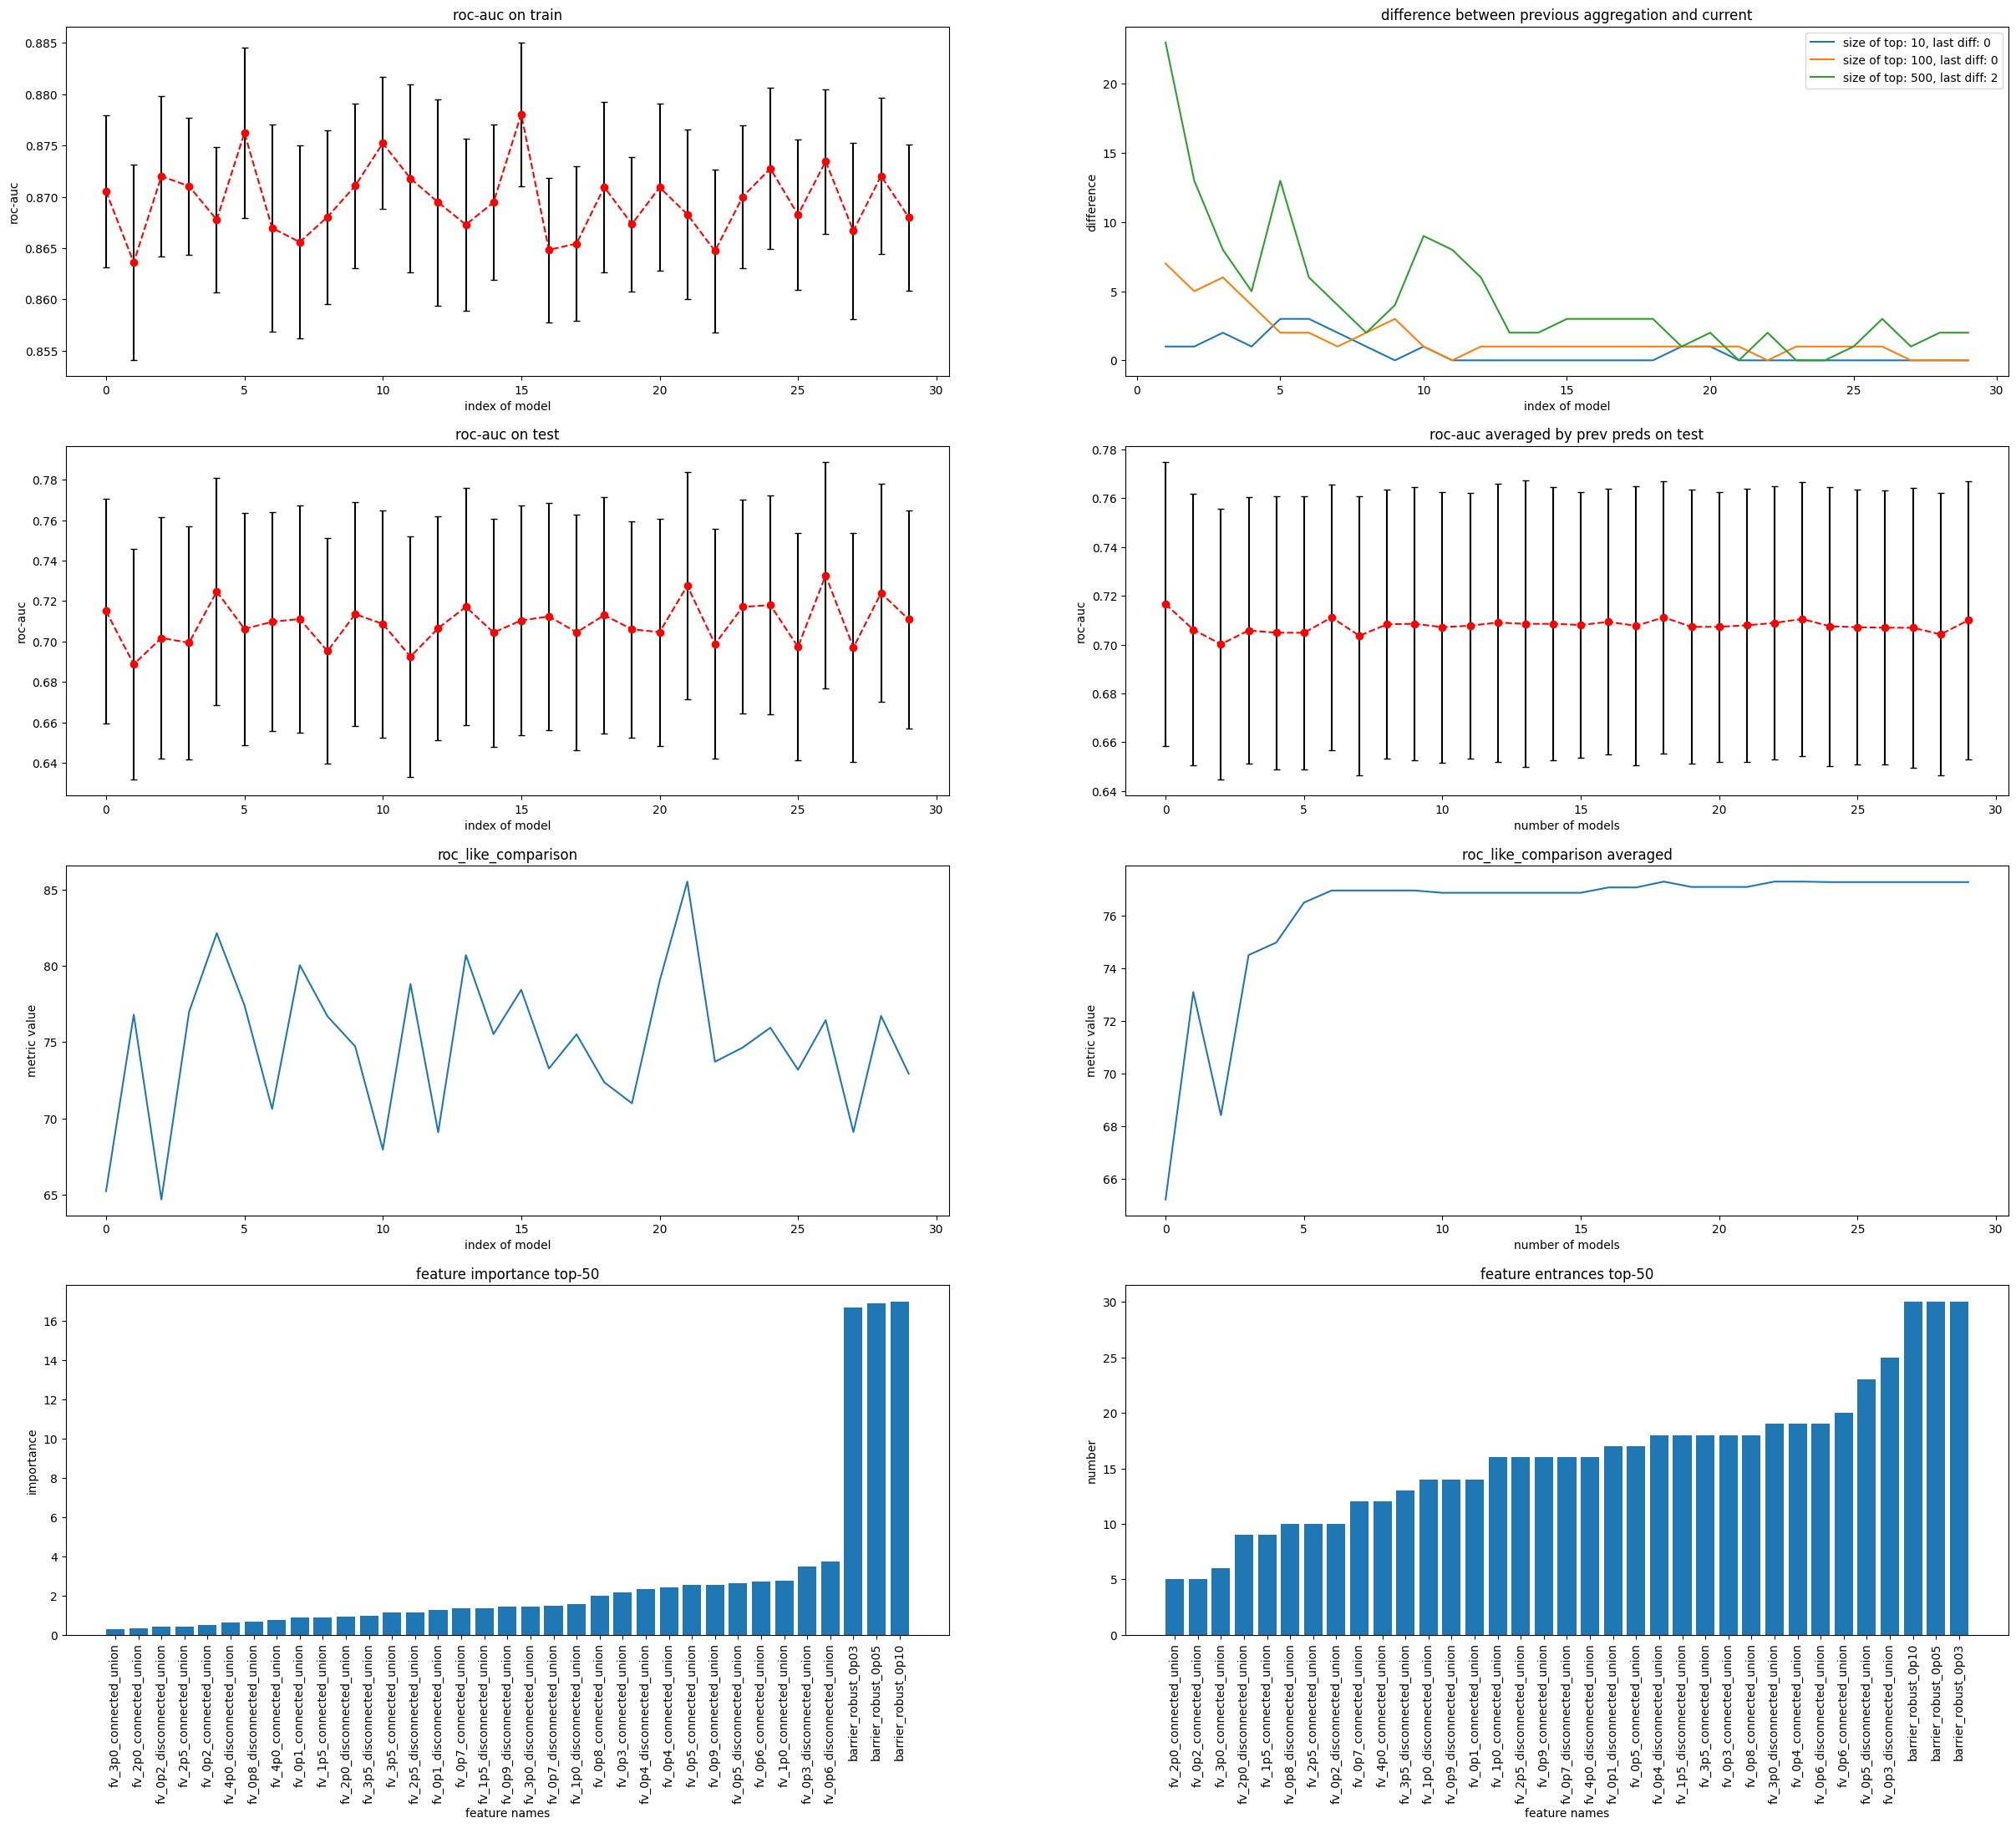

In [16]:
pipeline_catboost.plot_statistics()

In [17]:
preds_catboost_kahle = pipeline_catboost.preds_kahle_averaged[-1]
preds_catboost_mpdb = pipeline_catboost.preds_mpdb_averaged[-1]
preds_catboost_exp = pipeline_catboost.preds_exp_averaged[-1]

np.save('predictions/nn_catboost_kahle.npy', preds_catboost_kahle)
np.save('predictions/nn_catboost_mpdb.npy', preds_catboost_mpdb)
np.save('predictions/nn_catboost_exp.npy', preds_catboost_exp)


In [22]:
params = {
        "max_iter": 300,
    }

pipeline_logreg = ModelEvaluation(df_kahle_fin_nn, preds_Kahle2020, model_name = 'logreg', params = params)
pipeline_logreg.fit(X_kahle_nn, feature_weights_nn, thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names_nn)

pipeline_logreg.evaluate(num_of_evaluations = 30, X_mpdb = X_mpdb_nn, X_exp = X_exp_nn)
pipeline_logreg.get_aggregated_statistics()


  0%|          | 0/30 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.829438493995456
test roc-auc mean: 0.7031828727381522, std: 0.05467105930337507
mean train roc-auc: 0.8324492847496011


  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:07<03:43,  7.70s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 2/30 [00:15<03:36,  7.74s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 3/30 [00:22<03:24,  7.57s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [00:30<03:16,  7.54s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:38<03:09,  7.59s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 6/30 [00:45<03:01,  7.58s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 7/30 [00:53<02:53,  7.56s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 8/30 [01:00<02:45,  7.54s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 30%|███       | 9/30 [01:08<02:38,  7.56s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 33%|███▎      | 10/30 [01:15<02:31,  7.60s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 37%|███▋      | 11/30 [01:23<02:23,  7.57s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 12/30 [01:30<02:15,  7.54s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 43%|████▎     | 13/30 [01:38<02:07,  7.50s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 47%|████▋     | 14/30 [01:45<02:00,  7.51s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 15/30 [01:53<01:53,  7.58s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 53%|█████▎    | 16/30 [02:01<01:46,  7.59s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 57%|█████▋    | 17/30 [02:08<01:38,  7.59s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 18/30 [02:16<01:30,  7.58s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 63%|██████▎   | 19/30 [02:23<01:23,  7.57s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 67%|██████▋   | 20/30 [02:31<01:16,  7.65s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 21/30 [02:39<01:08,  7.64s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 73%|███████▎  | 22/30 [02:47<01:01,  7.68s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 77%|███████▋  | 23/30 [02:54<00:53,  7.70s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 24/30 [03:02<00:46,  7.74s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 83%|████████▎ | 25/30 [03:10<00:38,  7.77s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 26/30 [03:18<00:30,  7.72s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 90%|█████████ | 27/30 [03:25<00:23,  7.69s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 93%|█████████▎| 28/30 [03:33<00:15,  7.64s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 97%|█████████▋| 29/30 [03:40<00:07,  7.60s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 30/30 [03:48<00:00,  7.62s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
pipeline_logreg.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,8.324493e-01
1,roc_auc on test by aggregated preds,7.013554e-01
2,mean test roc-auc averaged by 40 models,7.035867e-01
3,roc_like_comparison by aggregated preds,7.605003e+01
4,roc_like_comparison averaged by 40 models,7.605003e+01
5,roc_like_comparison std,1.421085e-14


In [25]:
print(pipeline_logreg.show_results().to_markdown())

|    | statistic                                 |       result |
|---:|:------------------------------------------|-------------:|
|  0 | mean train roc-auc averaged by 40 models  |  0.832449    |
|  1 | roc_auc on test by aggregated preds       |  0.701355    |
|  2 | mean test roc-auc averaged by 40 models   |  0.703587    |
|  3 | roc_like_comparison by aggregated preds   | 76.05        |
|  4 | roc_like_comparison averaged by 40 models | 76.05        |
|  5 | roc_like_comparison std                   |  1.42109e-14 |


In [26]:
preds_logreg_kahle = pipeline_logreg.preds_kahle_averaged[-1]
preds_logreg_mpdb = pipeline_logreg.preds_mpdb_averaged[-1]
preds_logreg_exp = pipeline_logreg.preds_exp_averaged[-1]

np.save('predictions/nn_logreg_kahle.npy', preds_logreg_kahle)
np.save('predictions/nn_logreg_mpdb.npy', preds_logreg_mpdb)
np.save('predictions/nn_logreg_exp.npy', preds_logreg_exp)


EVALUATION STEP

In [1]:
from misc_utils import augment_Kahle2020
from misc_utils import augment_preds

from training_functions import *
from merging import *
from utils import *
from model_evaluation import ModelEvaluation
import pandas as pd

df_Kahle2020 = augment_Kahle2020.read_and_augment(
    "data_slim.csv",
)

preds_Kahle2020 = augment_preds.join_data_and_preds_Kahle2020(
    df_preds=pd.read_csv("datasets/exported.predictions.Kahle2020.v2.csv"),
    df_data=df_Kahle2020,
)

2024-09-10 15:51:39.689241: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 15:51:40.689657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Estimating lognorm D parameters


Making initial guess:   0%|          | 0/195 [00:00<?, ?it/s]

2024-09-10 15:51:54.236699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21041 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:06:00.0, compute capability: 8.6
2024-09-10 15:51:54.237318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8944 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5
2024-09-10 15:51:54.237822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9836 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


refining:   0%|          | 0/1000 [00:00<?, ?it/s]

In [2]:
from misc_utils.feature_analysis import (
    get_features_meta_info, plot_features_Kahle2020, PairwiseComparisonMetrics, ROClikeComparisonMetrics,
    plot_feature_roclikes, add_feature, add_feature_np
)

In [3]:
preds_logreg_kahle_nn = np.load('predictions/nn_logreg_kahle.npy', allow_pickle=True)
preds_logreg_kahle_nn.shape

(116,)

In [4]:
preds_logreg_kahle_nn = np.load('predictions/nn_logreg_kahle.npy', allow_pickle=True)
preds_logreg_mpdb_nn = np.load('predictions/nn_logreg_mpdb.npy', allow_pickle=True)
preds_logreg_exp_nn = np.load('predictions/nn_logreg_exp.npy', allow_pickle=True)

print(preds_logreg_kahle_nn.shape)
print(preds_logreg_mpdb_nn.shape)
print(preds_logreg_exp_nn.shape)

(116,)
(5996,)
(144,)


In [5]:
preds_catboost_kahle_nn = np.load('predictions/nn_catboost_kahle.npy', allow_pickle=True)
preds_catboost_mpdb_nn = np.load('predictions/nn_catboost_mpdb.npy', allow_pickle=True)
preds_catboost_exp_nn = np.load('predictions/nn_catboost_exp.npy', allow_pickle=True)

print(preds_catboost_kahle_nn.shape)
print(preds_catboost_mpdb_nn.shape)
print(preds_catboost_exp_nn.shape)

(116,)
(5996,)
(144,)


In [6]:
preds_mp = pd.read_csv("datasets/exported.predictions.mp.v2.csv")
ref_mp = pd.read_csv("datasets/mp_Laskowski2023_map.csv")

preds_mp_exp = join_data_and_preds_exp(
    df_preds_full_mp=preds_mp,
    df_data_exp_mp=ref_mp,
)

preds_icsd_exp = join_data_and_preds_icsd(
    df_preds_icsd=pd.read_csv("datasets/exported.predictions.icsd.v3.csv"),
    df_data_exp_full=pd.read_csv("datasets/digitized_data_for_SSEs.csv"),
)

preds_mp_exp = pd.concat([preds_mp_exp, preds_icsd_exp], axis=0).reset_index(drop=True)


In [7]:
all_features = get_features_meta_info(masking_options=("",))

[preds_Kahle2020, preds_mp_exp], all_features = add_feature_np(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    values = [preds_catboost_kahle_nn, preds_catboost_exp_nn],
    name = "nn_catboost",
    type = "nn_catboost",
    level=0.0,
)


[preds_Kahle2020, preds_mp_exp], all_features = add_feature_np(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    values = [preds_logreg_kahle_nn, preds_logreg_exp_nn],
    name = "nn_logreg",
    type = "nn_logreg",
    level=0.0,
)

sigmoid = lambda x, steepness=10: 1.0 / (1.0 + np.exp(-x * steepness))

[preds_Kahle2020, preds_mp_exp], all_features = add_feature(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    func=lambda x: (
        sigmoid(np.log10(x["fv_0p5_connected_union"]) + 2.00)
        * sigmoid(np.log10(x["fv_0p5_disconnected_union"]) + 1.15)
    ),
    name="manual_combination",
    type="manual_combination",
    level=0.0,
)

[preds_Kahle2020, preds_mp_exp], all_features = add_feature(
    [preds_Kahle2020, preds_mp_exp],
    all_features,
    func=lambda x: (
        np.random.default_rng(42).uniform(0.01, 1.0, size=len(x))
    ),
    name="random_guess",
    type="random_guess",
    level=0.0,
)

In [8]:
exp_pos = preds_mp_exp.query(
    "sigma_S_cm.replace('<1E-10', '1e-10').astype('float') >= 5e-5"
)["sample_weight"].sum()
exp_neg = preds_mp_exp.query(
    "sigma_S_cm.replace('<1E-10', '1e-10').astype('float') <= 1e-5"
)["sample_weight"].sum()


sim_pos = len(preds_Kahle2020.query("log10condNE300 >= -2.5"))
sim_pos_base = len(preds_Kahle2020.query("condNE1000 >= 0.1"))
sim_neg = len(preds_Kahle2020.query("condNE1000 <= 1e-2"))

print(f"exp          p/n: {exp_pos:.0f} / {exp_neg:.0f} = {exp_pos / exp_neg:.3f}")
print(f"sim (base)   p/n: {sim_pos_base:.0f} / {sim_neg:.0f} = {sim_pos_base / sim_neg:.3f}")
print(f"sim (extrap) p/n: {sim_pos:.0f} / {sim_neg:.0f} = {sim_pos / sim_neg:.3f}")


exp          p/n: 6 / 76 = 0.079
sim (base)   p/n: 31 / 64 = 0.484
sim (extrap) p/n: 4 / 64 = 0.062


In [9]:
roclike_metrics = ROClikeComparisonMetrics()

feature_scores_experimental = roclike_metrics.eval_features(
    preds_df=preds_mp_exp,
    features_meta_info=all_features,
    positive_thr=5e-5,
    negative_thr=1e-5,
    weight_validation_plots=False,
    dataset_type="experimental",
    experimental_error_relative=1.0,
    num_bootstrap_samples=1000,
    num_negatives_max=0.1 * exp_neg,
)

feature_scores_base = roclike_metrics.eval_features(
    preds_df=preds_Kahle2020,
    features_meta_info=all_features,
    num_bootstrap_samples=1000,
    num_negatives_max=0.1 * sim_neg,
    positive_on_extrap300=False,
    weight_validation_plots=False,
)

feature_scores_extrap300 = roclike_metrics.eval_features(
    preds_df=preds_Kahle2020,
    features_meta_info=all_features,
    num_bootstrap_samples=1000,
    # num_negatives_max=2.0,
    num_negatives_max=0.1 * sim_neg,
    positive_on_extrap300=True,
    positive_thr=-2.5,
    weight_validation_plots=False,
)


Found sample weights!


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

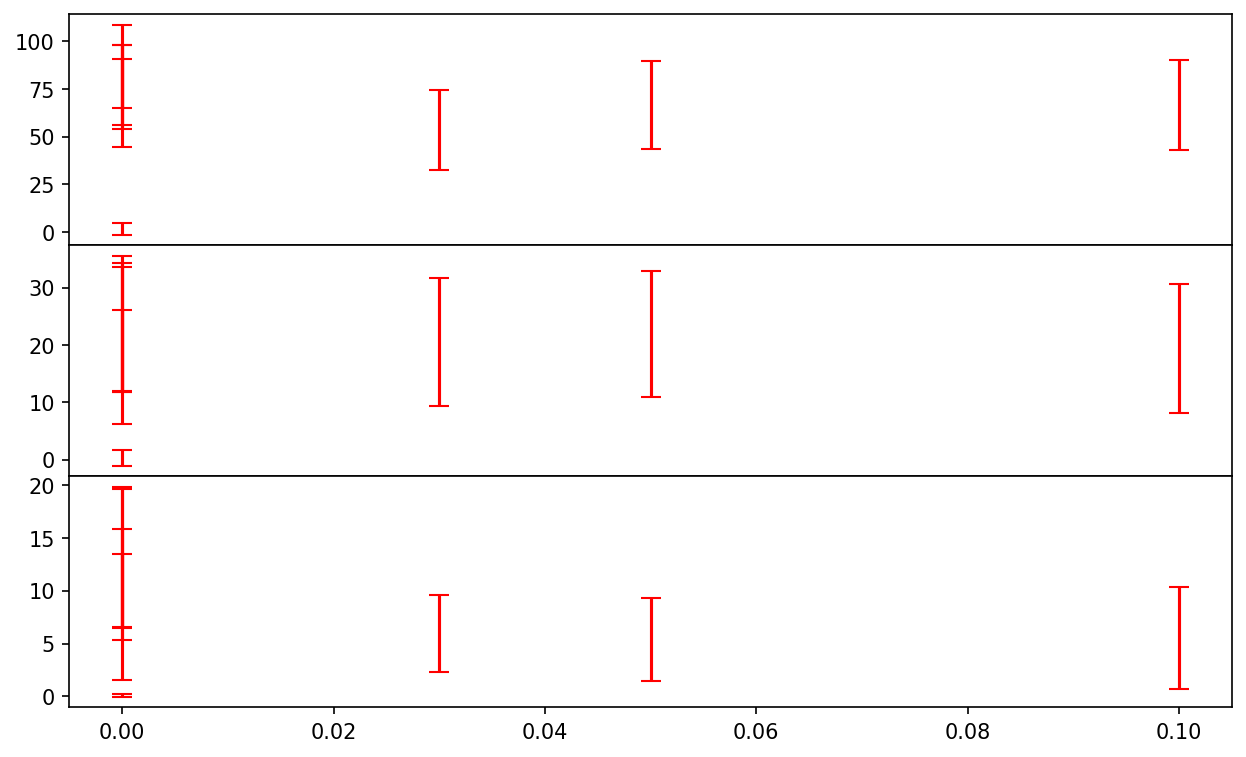

In [19]:
from pathlib import Path
out_path = Path("fv.analysis.2.3_finilizingPlots")
if not out_path.exists():
    out_path.mkdir()
    
fig = plt.figure(figsize=(10, 6), dpi=150)

label_map = dict(
    barrier="MPE",
    nn_catboost = "NN catboost",
    nn_logreg = "NN logreg",
    manual_combination="Manual combination",
    random_guess="Random guess",
)

for i_plt, (score_type, score_vals, score_errs) in enumerate([
    ("ROC-AUC\n(AIMD, base)", feature_scores_base["score"], (feature_scores_base["score_bs_q84"] - feature_scores_base["score_bs_q16"]) / 2),
    ("ROC-AUC\n(AIMD, extrap.)", feature_scores_extrap300["score"], (feature_scores_extrap300["score_bs_q84"] - feature_scores_extrap300["score_bs_q16"]) / 2),
    ("ROC-AUC\n(experimental)", feature_scores_experimental["score"], (feature_scores_experimental["score_bs_q84"] - feature_scores_experimental["score_bs_q16"]) / 2),
], 1):
    plt.subplot(3, 1, i_plt, sharex=None if i_plt == 1 else plt.gca())
    groups = {t: g for t, g in all_features.groupby("type")}
    for t in label_map.keys():
        g = groups[t]
        # if "fv" in t:
        #     pass
        #     # plt.errorbar(
        #     #     g["level"], score_vals.loc[g.index], yerr=score_errs.loc[g.index],
        #     #     label=label_map[t], fmt="o", capsize=2.0, alpha=0.8, ms=4.0,
        #     # )
        # else:

        
        yval = score_vals.loc[g.index].iloc[0]
        yerr = score_errs.loc[g.index].iloc[0]
            # (l,) = plt.plot([0.0, 4.0], [yval] * 2, '--', label=label_map[t])
            # plt.fill_between([0.0, 4.0,], [yval + yerr] * 2, [yval - yerr] * 2, color=l.get_color(), alpha=0.1)

        # plt.errorbar(
        #         g["level"], score_vals.loc[g.index], yerr=score_errs.loc[g.index],
        #         label=label_map[t], fmt="o", capsize=2.0, alpha=0.8, ms=4.0,
        #     )
        # plt.scatter()
        plt.errorbar(g['level'], score_vals.loc[g.index], 
             yerr=score_errs.loc[g.index], fmt='none', c='red', capsize=5)


    # if i_plt == 1:
    #     handles, labels = plt.gca().get_legend_handles_labels()
    #     lh_dict = {l: h for l, h in zip(labels, handles)}
    #     labels = list(label_map.values())
    #     handles = [lh_dict[l] for l in labels]
    #     plt.legend(handles, labels, fontsize=6)
#     plt.grid(axis='x', visible=True)
#     plt.ylabel(score_type, fontsize=8)
#     plt.xlim(-0.2, 4.9)
# plt.xlabel("FV threshold [eV]")

fig.subplots_adjust(hspace=0)
fig.savefig(out_path / "feature_evaluation.pdf")

In [32]:
feature_scores_base = feature_scores_base.reset_index()

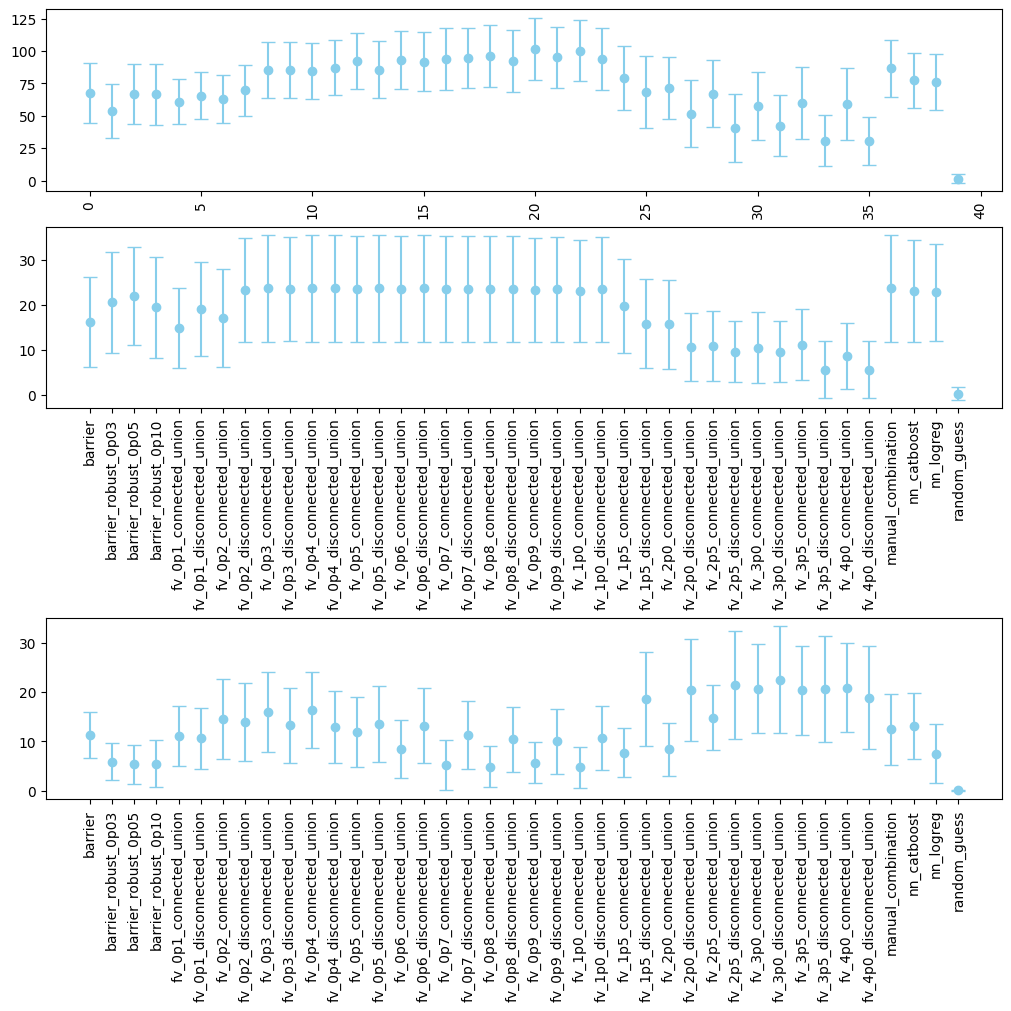

In [67]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10),
                       constrained_layout = True)

for i_plt, (score_type, score_features, score_vals, score_errs) in enumerate([
    ("ROC-AUC\n(AIMD, base)", feature_scores_base.index, feature_scores_base["score"], (feature_scores_base["score_bs_q84"] - feature_scores_base["score_bs_q16"]) / 2),
    ("ROC-AUC\n(AIMD, extrap.)", feature_scores_extrap300.index, feature_scores_extrap300["score"], (feature_scores_extrap300["score_bs_q84"] - feature_scores_extrap300["score_bs_q16"]) / 2),
    ("ROC-AUC\n(experimental)", feature_scores_experimental.index, feature_scores_experimental["score"], (feature_scores_experimental["score_bs_q84"] - feature_scores_experimental["score_bs_q16"]) / 2),
], 0):
    groups = {t: g for t, g in all_features.groupby("type")}
    ax[i_plt].scatter(x = score_features, y = score_vals, color='skyblue')
    ax[i_plt].errorbar(score_features, score_vals, yerr = score_errs, fmt='none', c='skyblue', capsize=5)
    ax[i_plt].tick_params(axis='x', labelrotation=90)


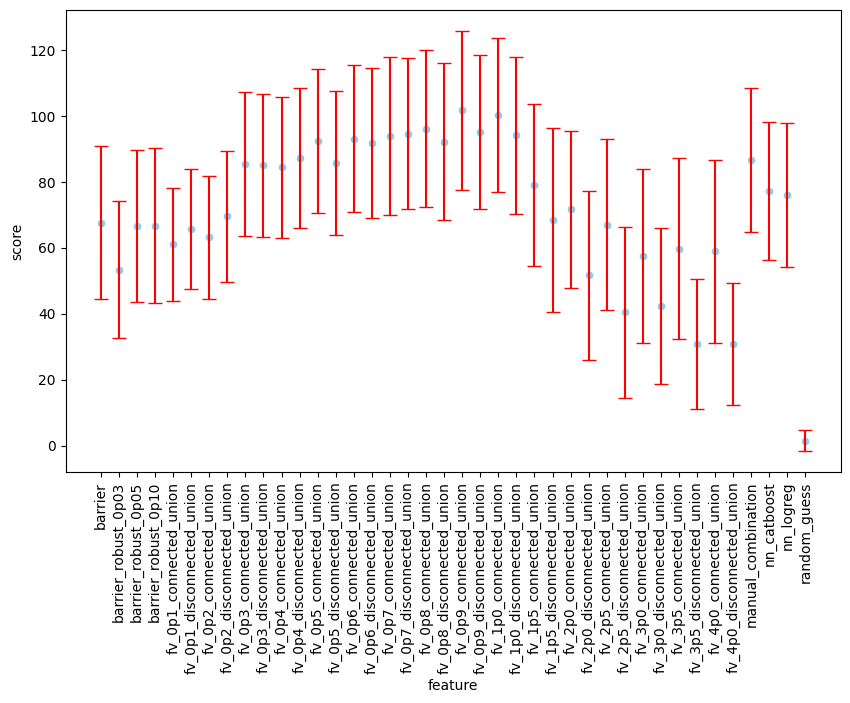

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Sample data
# data = {
#     'Variable': ['A', 'B', 'C', 'D'],
#     'Score': [20, 35, 30, 35],
#     'StdDev': [2, 3, 4, 5]  # Standard deviations for confidence intervals
# }

# # Create a DataFrame
# df = pd.DataFrame(data)

# # Calculate the confidence intervals (95% CI)
# n = 30  # Sample size for each variable
# confidence_interval = 1.96 * (df['StdDev'] / np.sqrt(n))

# Calculate the starting point for each bar (the mean of scores)
# mean_score = feature_scores_base['score'].mean()
# feature_scores_base['adjusted_score'] = feature_scores_base['score'] - mean_score

# # Plotting
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x = 'feature', y = 'score', data = feature_scores_base, color='skyblue')

# plt.xticks(rotation = 90)
 
# # Adding error bars for confidence intervals

# plt.errorbar(feature_scores_base['feature'], feature_scores_base['score'], 
#              yerr = (feature_scores_base["score_bs_q84"] - feature_scores_base["score_bs_q16"]) / 2, fmt='none', c='red', capsize=5)

# Adding labels and title
# plt.title('Scores by Variable Adjusted from Mean with Confidence Intervals')
# plt.xlabel('Variable')
# plt.ylabel('Adjusted Score (from Mean)')
# plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Line at y=0 for reference

# Show the plot
# plt.show()


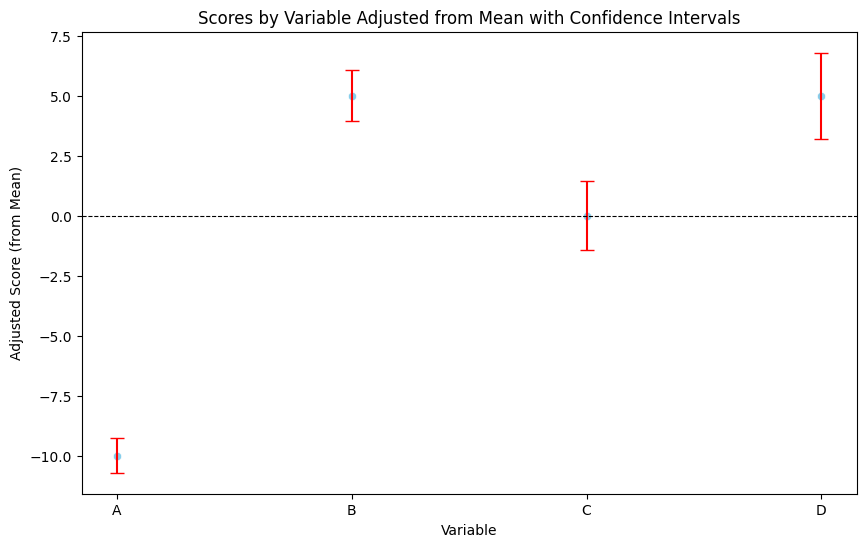

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
data = {
    'Variable': ['A', 'B', 'C', 'D'],
    'Score': [20, 35, 30, 35],
    'StdDev': [2, 3, 4, 5]  # Standard deviations for confidence intervals
}

# Create a DataFrame
df = pd.DataFrame(data)

# Calculate the confidence intervals (95% CI)
n = 30  # Sample size for each variable
confidence_interval = 1.96 * (df['StdDev'] / np.sqrt(n))

# Calculate the starting point for each bar (the mean of scores)
mean_score = df['Score'].mean()
df['Adjusted_Score'] = df['Score'] - mean_score

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Variable', y='Adjusted_Score', data=df, color='skyblue')

# Adding error bars for confidence intervals
plt.errorbar(df['Variable'], df['Adjusted_Score'], 
             yerr=confidence_interval, fmt='none', c='red', capsize=5)

# Adding labels and title
plt.title('Scores by Variable Adjusted from Mean with Confidence Intervals')
plt.xlabel('Variable')
plt.ylabel('Adjusted Score (from Mean)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Line at y=0 for reference

# Show the plot
plt.show()


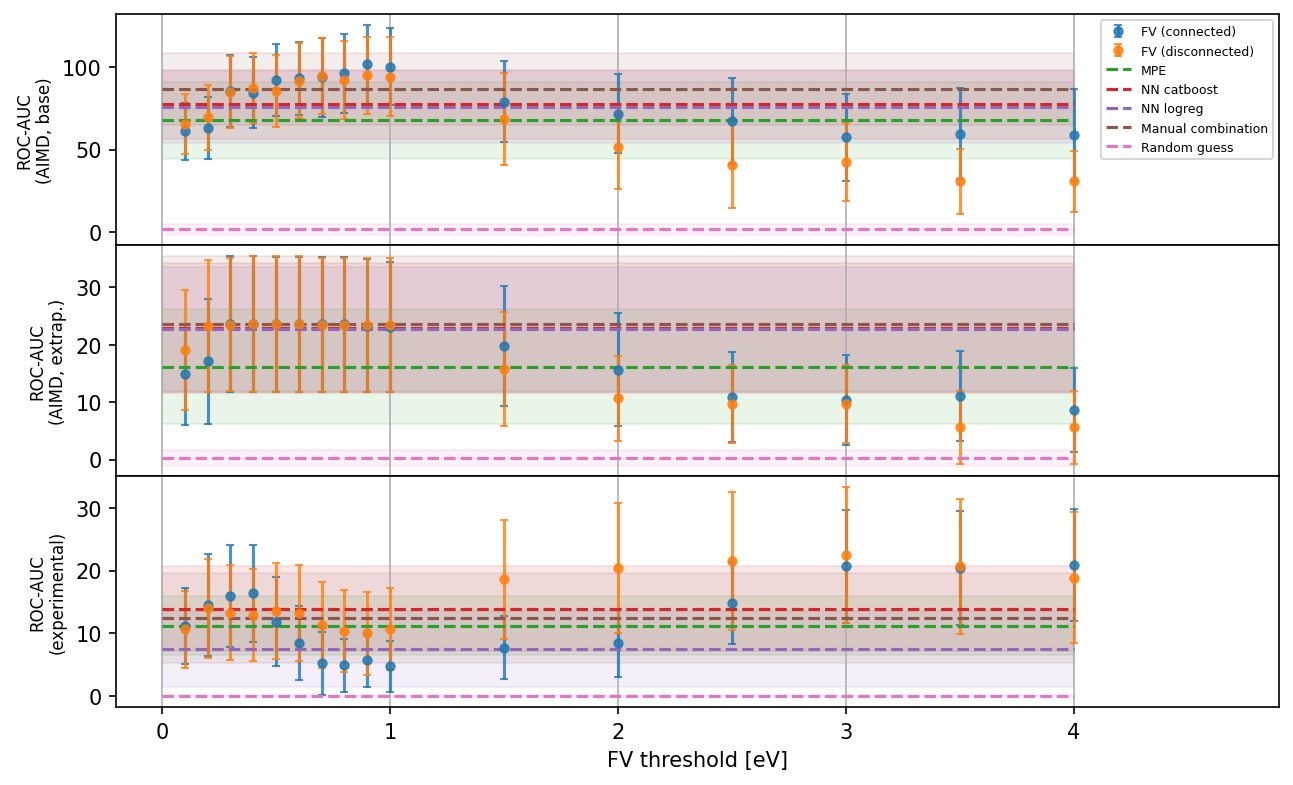

In [ ]:
# from pathlib import Path
# out_path = Path("fv.analysis.2.3_finilizingPlots")
# if not out_path.exists():
#     out_path.mkdir()
    
# fig = plt.figure(figsize=(10, 6), dpi=150)

# label_map = dict(
#     fv_connected="FV (connected)",
#     fv_disconnected="FV (disconnected)",
#     barrier="MPE",
#     nn_catboost = "NN catboost",
#     nn_logreg = "NN logreg",
#     manual_combination="Manual combination",
#     random_guess="Random guess",
# )

# for i_plt, (score_type, score_vals, score_errs) in enumerate([
#     ("ROC-AUC\n(AIMD, base)", feature_scores_base["score"], (feature_scores_base["score_bs_q84"] - feature_scores_base["score_bs_q16"]) / 2),
#     ("ROC-AUC\n(AIMD, extrap.)", feature_scores_extrap300["score"], (feature_scores_extrap300["score_bs_q84"] - feature_scores_extrap300["score_bs_q16"]) / 2),
#     ("ROC-AUC\n(experimental)", feature_scores_experimental["score"], (feature_scores_experimental["score_bs_q84"] - feature_scores_experimental["score_bs_q16"]) / 2),
# ], 1):
#     plt.subplot(3, 1, i_plt, sharex=None if i_plt == 1 else plt.gca())
#     groups = {t: g for t, g in all_features.groupby("type")}
#     for t in label_map.keys():
#         g = groups[t]
#         if "fv" in t:
#             plt.errorbar(
#                 g["level"], score_vals.loc[g.index], yerr=score_errs.loc[g.index],
#                 label=label_map[t], fmt="o", capsize=2.0, alpha=0.8, ms=4.0,
#             )
#         else:
#             yval = score_vals.loc[g.index].iloc[0]
#             yerr = score_errs.loc[g.index].iloc[0]
#             (l,) = plt.plot([0.0, 4.0], [yval] * 2, '--', label=label_map[t])
#             plt.fill_between([0.0, 4.0,], [yval + yerr] * 2, [yval - yerr] * 2, color=l.get_color(), alpha=0.1)
#     if i_plt == 1:
#         handles, labels = plt.gca().get_legend_handles_labels()
#         lh_dict = {l: h for l, h in zip(labels, handles)}
#         labels = list(label_map.values())
#         handles = [lh_dict[l] for l in labels]
#         plt.legend(handles, labels, fontsize=6)
#     plt.grid(axis='x', visible=True)
#     plt.ylabel(score_type, fontsize=8)
#     plt.xlim(-0.2, 4.9)
# plt.xlabel("FV threshold [eV]")

# fig.subplots_adjust(hspace=0)
# fig.savefig(out_path / "feature_evaluation.pdf")